**About** : This notebook is used to prepare the data


In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

## Initialization

### Imports

In [2]:
import os
import sys
import cv2
import torch
import warnings
import pycocotools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

sys.path.append("../src/")

In [3]:
from params import *
from utils.rle import *
from utils.plots import *
from data.masks import *

## Data

In [4]:
df = pd.read_csv(DATA_PATH + "train.csv")

In [5]:
df = df.groupby('id').agg(list).reset_index()

In [6]:
for col in df.columns[2:]:
    df[col] = df[col].apply(lambda x: np.unique(x)[0] if len(np.unique(x)) == 1 else np.unique(x))

In [7]:
df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 360...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F8-3_Vessel-361_Ph_4,0 days 09:00:00
2,01ae5a43a2ab,[241026 3 241726 9 242427 13 243130 14 243834 ...,704,520,cort,13h30m00s,2020-11-04,cort[oka-high]_B5-1_Vessel-377_Ph_1,0 days 13:30:00
3,026b3c2c4b32,[170753 5 171454 12 172158 13 172862 13 173565...,704,520,cort,19h30m00s,2020-11-04,cort[oka-low]_H6-2_Vessel-377_Ph_2,0 days 19:30:00
4,029e5b3b89c7,[139142 7 139845 10 140548 13 141251 15 141955...,704,520,cort,13h30m00s,2020-10-27,cort[pre-treat]_B8-2_Vessel-377_Ph_2,0 days 13:30:00


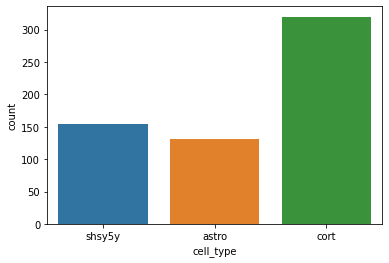

In [8]:
sns.countplot(x=df['cell_type'])
plt.show()

In [9]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


def get_img_and_mask(img_path, annotation, width, height, mask_only=False):
    """ Capture the relevant image array as well as the image mask """
    img_mask = np.zeros((len(annotation), height, width), dtype=np.uint16)
    
    
    for i, annot in enumerate(annotation): 
        img_mask[i] = rle_decode(annot, (height, width))
    
    return img_mask

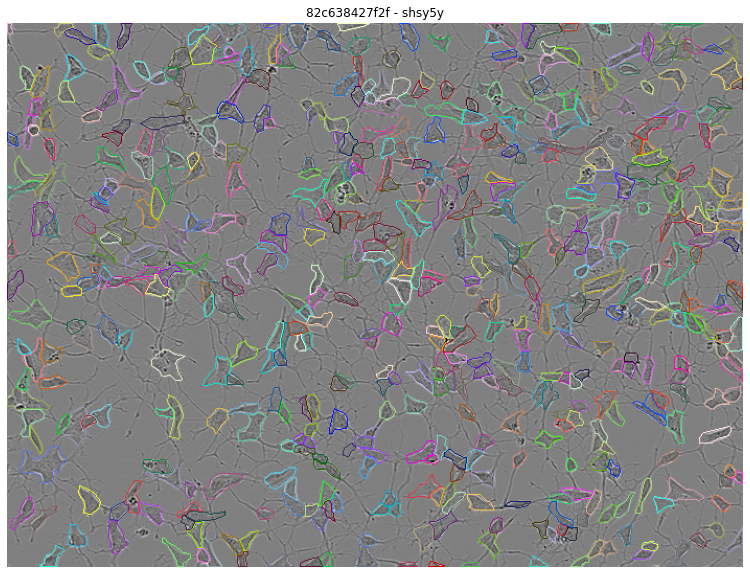

In [10]:
for _ in range(5):
#     idx = np.random.choice(len(df))
    idx = 313

    img = cv2.imread(TRAIN_IMG_PATH + df['id'][idx] + ".png")

    rles = df['annotation'][idx]
    
    mask = rles_to_mask_fix(rles, img.shape[:2], single_channel=False, fix=True)
    
    plt.figure(figsize=(15, 10))
    plot_sample(img, mask, width=1)
    plt.axis(False)
    plt.title(f"{df['id'][idx]} - {df['cell_type'][idx]}")
    plt.show()
    
    break

## Generation

### Function

In [11]:
def prepare_mmdet_data(df, idx, fix=True):
    height, width = df[["height", "width"]].values[idx]
    cell_type = df['cell_type'][idx]
    
    rles = df['annotation'][idx]
    masks = rles_to_mask_fix(rles, (height, width), single_channel=False, fix=fix)

    rles = [pycocotools.mask.encode(np.asfortranarray(m > 0)) for m in masks]

    bboxes = np.array([pycocotools.mask.toBbox(rle) for rle in rles])
    bboxes[:, 2] += bboxes[:, 0]
    bboxes[:, 3] += bboxes[:, 1]
    
    meta = {
        'filename': df['id'][idx] + ".png",
        'width': int(width),
        'height': int(height),
        'cell_type': cell_type,
        'ann': {
            'bboxes': bboxes.astype(int).tolist(),
            'labels': [CELL_TYPES.index(cell_type)] * len(bboxes),
            'masks': rles
        }
    }
    
    return masks, meta

### Test

In [12]:
metas = []

for idx in tqdm(range(len(df))):
    idx = 313
    img = cv2.imread(TRAIN_IMG_PATH + df['id'][idx] + ".png")
    masks, meta = prepare_mmdet_data(df, idx)
    
    metas.append(meta)
    
    if idx > 2:
        break

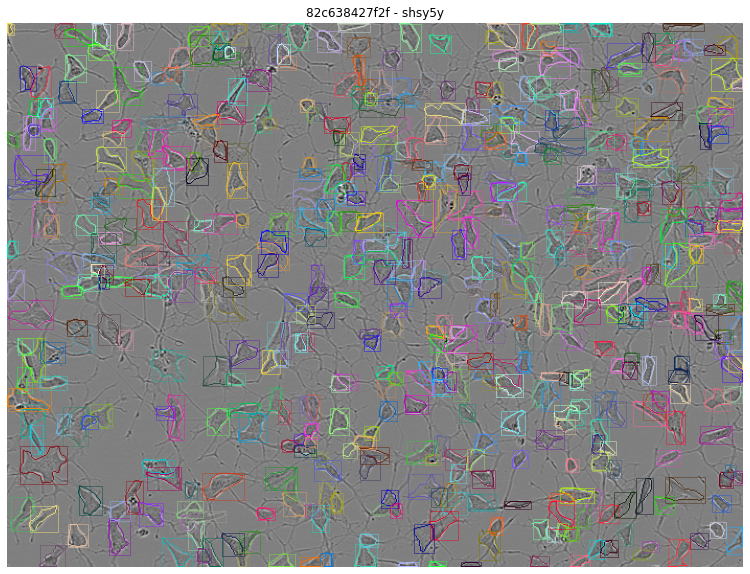

In [13]:
plt.figure(figsize=(15, 10))
plot_sample(img, masks.max(0), meta['ann']['bboxes'], width=1)
plt.axis(False)
plt.title(f"{df['id'][idx]} - {df['cell_type'][idx]}")
plt.show()

### Run

In [15]:
from multiprocessing import Pool

p = Pool(processes=4)

df = pd.read_csv(DATA_PATH + "train.csv")
df = df.groupby('id').agg(list).reset_index()
for col in df.columns[2:]:
    df[col] = df[col].apply(lambda x: np.unique(x)[0] if len(np.unique(x)) == 1 else np.unique(x))

def prepare_mmdet_data_(i):
    return prepare_mmdet_data(df, idx=i, fix=True)

metas = []
for _, meta in tqdm(p.imap(prepare_mmdet_data_, range(len(df))), total=len(df)):
    metas.append(meta)

meta_df = pd.DataFrame.from_dict(metas)
if len(meta_df) == len(df):
    meta_df.to_csv(OUT_PATH + "mmdet_data.csv", index=False)